#### identifying nodules using trained network

In [236]:
import numpy as np
import cv2
import time
from glob import glob
import os
import matplotlib.pylab as plt
from sklearn.externals import joblib
from skimage import measure
from skimage.transform import resize
import ntpath
%matplotlib inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#p = sns.color_palette()
from skimage.draw import circle
import re
import traceback

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('numpy','matplotlib','cv2','sklearn','skimage','scipy','pandas')

numpy: 1.11.2
matplotlib: 1.5.1
cv2: 3.1.0
sklearn: 0.18.1
skimage: 0.12.3
scipy: 0.18.1
pandas: 0.19.2


## settings

In [190]:
working_path = "/media/mra/win7/data/misc/kaggle/datascience2017/python/DSB3Tutorial/tutorial_code/output/numpy/luna/allsubsets/"

# path to dicom folder, stage1 data
path2dicom='/media/mra/My Passport/Kaggle/datascience2017/stage1/'

# original data dimension
img_rows = 512
img_cols = 512


# batch size
bs=16

# trained data dimesnsion
h,w=256,256

# exeriment name to record weights and scores
experiment='coords_aug'+'_hw_'+str(h)+'by'+str(w)
print ('experiment:', experiment)

# seed point
seed = 2016
seed = np.random.randint(seed)

# checkpoint
weightfolder='./output/weights/'+experiment
if  not os.path.exists(weightfolder):
    #print ('weights folder does not exist!')
    raise IOError("Path to weights does not exist!")

# number of outputs
nb_output=3 # (r,c,radius)


('experiment:', 'coords_aug_hw_256by256')


## utils

In [271]:
# functions
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Dropout
from keras.layers import Activation,Reshape,Permute,Flatten,Dense
from keras.layers.advanced_activations import ELU
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.models import Sequential

from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K


# model
def model(params):

    h=params['img_rows']
    w=params['img_cols']
    lr=params['learning_rate']
    weights_path=params['weights_path']
    loss=params['loss']
    C=params['nb_filters']
    nb_output=params['nb_output']
    
    model = Sequential()
    
    model.add(Convolution2D(C, 3, 3, activation='relu',subsample=(2,2),border_mode='same', input_shape=(1, h, w)))

    N=6
    for k in range(1,N):
        C1=np.min([2**k*C,512])
        model.add(Convolution2D(C1, 3, 3, activation='relu', subsample=(1,1), border_mode='same'))              
        model.add(Convolution2D(C1, 3, 3, subsample=(1,1), activation='relu', border_mode='same'))              
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
    model.add(Convolution2D(C1, 3, 3, activation='relu', border_mode='same'))              
    model.add(Convolution2D(C1, 3, 3, activation='relu', border_mode='same'))              
    #model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.1))

    model.add(Dense(nb_output, activation='sigmoid'))
    
    #load previous weights
    if weights_path:
        model.load_weights(weights_path)

    model.compile(loss=loss, optimizer=Adam(lr))

    return model


# preprocess
def preprocess(X,Y,param_prep):
    # X,Y: n,c,h,w
    N,C,H,W=X.shape
    
    if Y is None:
        Y=np.zeros_like(X,dtype='uint8')
    
    # get params
    h=param_prep['h']
    w=param_prep['w']    
    crop=param_prep['crop']
    norm_type=param_prep['norm_type'] # normalization 
    output=param_prep['output'] # output
    
    
    # center crop h*w
    if crop is 'center':
        hc=(H-h)/2
        wc=(W-w)/2
        X=X[:,:,hc:H-hc,wc:W-wc]
        Y=Y[:,:,hc:H-hc,wc:W-wc]
    elif crop is 'random':
        hc=(H-h)/2
        wc=(W-w)/2
        hcr=np.random.randint(hc)
        wcr=np.random.randint(wc)
        X=X[:,:,hcr:H-hcr,wcr:W-wcr]
        Y=Y[:,:,hcr:H-hcr,wcr:W-wcr]
        
    # check if need to downsample
    # resize if needed
    if h<H:
        X_r=np.zeros([N,C,h,w],dtype=X.dtype)
        Y_r=np.zeros([N,C,h,w],dtype='uint8')
        for k1 in range(X.shape[0]):
            X_r[k1] = cv2.resize(X[k1,0], (w, h), interpolation=cv2.INTER_CUBIC)
            Y_r[k1] = cv2.resize(Y[k1,0], (w, h), interpolation=cv2.INTER_CUBIC)>0.5 # binary mask 
    else:
        X_r=X
        Y_r=Y

    
    X_r=np.array(X_r,dtype='float32')
    if norm_type is 'global':
        X_r-=np.mean(X_r)
        X_r/=np.std(X_r)
    elif norm_type is 'local':
        for k in range(X_r.shape[0]):
            mean = np.mean(X_r[k,0])  # mean       
            sigma = np.std(X_r[k,0])  # std
            if sigma<1e-5:
                sigma=1
            X_r[k] = X_r[k]-mean
            X_r[k] = X_r[k]/ sigma
    elif norm_type is 'scale':
        X_r-=np.min(X_r)
        X_r/=np.max(X_r)
    elif norm_type is 'minmax_bound':        
        # normalization
        MIN_BOUND = -1000.0
        MAX_BOUND = 400.0
        
        X_r = (X_r - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        X_r[X_r>1] = 1.
        X_r[X_r<0] = 0.

    # center coordinates and diameter
    y_r=mask2coord(Y_r)            
    
    if output is 'mask':    
        return X_r,Y_r
    elif output is 'coords':
        return X_r,y_r

def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))



def image_with_mask(img, mask,color=(0,255,0)):
    maximg=np.max(img)    
    img=np.asarray(img,dtype='float32')
    img=np.asarray((img/maximg)*255,dtype='uint8')
    mask=np.asarray(mask,dtype='uint8') 
    if np.max(mask)==1:
        mask=mask*255

    # returns a copy of the image with edges of the mask added in red
    if len(img.shape)==2:	
	img_color = grays_to_RGB(img)
    else:
	img_color =img

    mask_edges = cv2.Canny(mask, 100, 200) > 0
    img_color[mask_edges, 0] = color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = color[1]
    img_color[mask_edges, 2] = color[2]
    img_color=img_color#/float(np.max(img))
    return img_color

def disp_img_2masks(img,mask1,mask2,r=1,c=1,d=0,indices=None):
    if mask1 is None:
        mask1=np.zeros(img.shape,dtype='uint8')
    if mask2 is None:
        mask2=np.zeros(img.shape,dtype='uint8')
        
    N=r*c    
    if d==2:
        # convert to N*C*H*W
        img=np.transpose(img,(2,0,1))
        img=np.expand_dims(img,axis=1)
        
        mask1=np.transpose(mask1,(2,0,1))
        mask1=np.expand_dims(mask1,axis=1)

        mask2=np.transpose(mask2,(2,0,1))
        mask2=np.expand_dims(mask2,axis=1)
        
    if indices is None:    
        # random indices   
        n1=np.random.randint(img.shape[0],size=N)
    else:
        n1=indices
    
    I1=img[n1,0]
    #M1=mask1[n1,0]
    M1=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask1.shape[1]):
        M1=np.logical_or(M1,mask1[n1,c1,:])    
    #M2=mask2[n1,0]
    M2=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask2.shape[1]):
        M2=np.logical_or(M2,mask2[n1,c1,:])    
    
    C1=(0,255,9)
    C2=(255,0,0)
    for k in range(N):    
        imgmask=image_with_mask(I1[k],M1[k],C1)
        imgmask=image_with_mask(imgmask,M2[k],C2)
        plt.subplot(r,c,k+1)
        plt.imshow(imgmask)
        plt.title(n1[k])
    plt.show()            
    return n1        




def array_stats(X):
    X=np.asarray(X)
    
    # get var name
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    
    print (vars_name,X.shape, X.dtype)
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print ('min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X)))
    
    print '-'*50

# convert mask to coordinates
def mask2coord(Y):
    N,C,H,W=Y.shape
    coords=np.zeros((N,3))
    for k in range(N):
        region=measure.regionprops(Y[k,0])
        if len(region)>0:
            (x,y),radius = cv2.minEnclosingCircle(region[0].coords)
            coords[k,:]=[x,y,radius]
    R=100
    #print np.max(coords[:,2])
    coords=coords/[H,W,R]
    coords=coords[:,:nb_output]
    return coords

# convert coordinates to mask
def coord2mask(y_pred,params):
    h,w,R=params
    n=len(y_pred)
    Y_pred=np.zeros((n,1,h,w),dtype='uint8')
    for k1 in range(n):
        img = np.zeros((h, w), dtype=np.uint8)
        r,c,radius=y_pred[k1,:]*[h,w,R]
        rr, cc = circle(r,c,radius)
        img[rr, cc] = 1
        Y_pred[k1,:]=img
    return Y_pred    


#scan=load_scan(path2dicom+p_id)
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
       
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    #image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


### load test data from LUNA 2016 data set

In [249]:
# load test data
X_test = joblib.load(working_path+"testX.joblib")
Y_test = joblib.load(working_path+"testY.joblib")
array_stats(X_test)
array_stats(Y_test)


(u'X_test', (357, 1, 512, 512), dtype('int16'))
min: -3226, max: 9180, avg: -8.18e+02, std:8.94e+02
--------------------------------------------------
(u'Y_test', (357, 1, 512, 512), dtype('uint8'))
min: 0, max: 1, avg: 0.00222, std:0.0471
--------------------------------------------------


### checking Hisograms

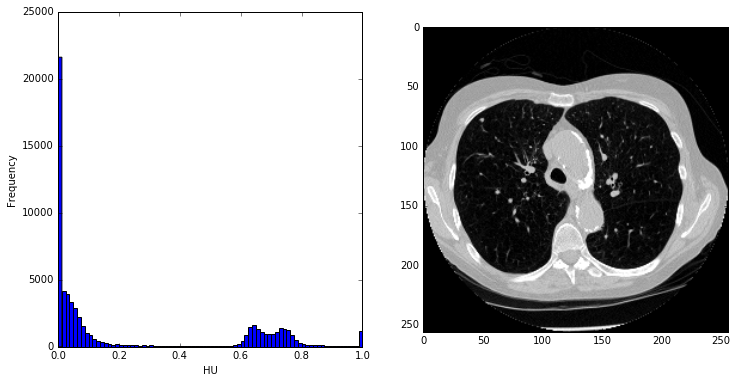

In [252]:
sn=70

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(X_test[sn].flatten(), bins=80)
plt.xlabel("HU")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,2,2)
plt.imshow(X_test[sn,0], cmap='gray')
plt.show()

## preprocessing

(u'X_test', (357, 1, 256, 256), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.305, std:0.337
--------------------------------------------------
(u'Y_test', (357, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.00219, std:0.0468
--------------------------------------------------


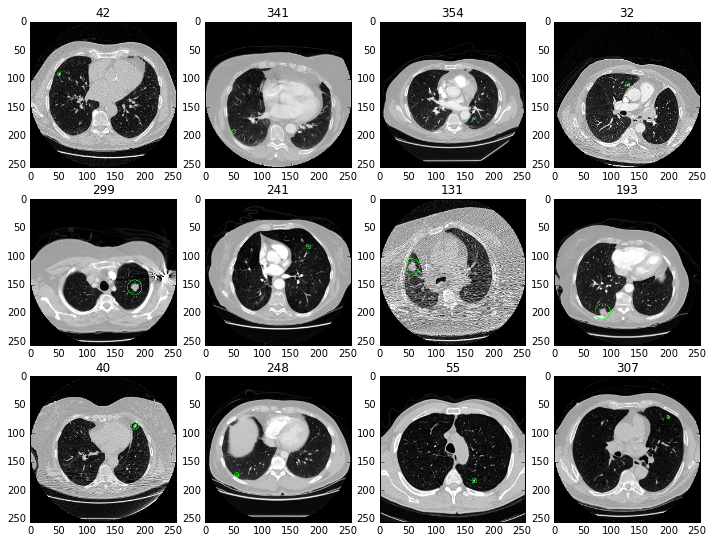

In [250]:
# pre-processing 
param_prep={
    'h': h,
    'w': w,
    'crop'    : None,
    'norm_type' : 'minmax_bound',
    'output' : 'mask',
}
X_test,Y_test=preprocess(X_test,Y_test,param_prep)
array_stats(X_test)
array_stats(Y_test)


t=3
plt.figure(figsize=(4*t,3*t))
n1=disp_img_2masks(X_test,Y_test,None,3,4,True)

#### checking histogram after pre-processing

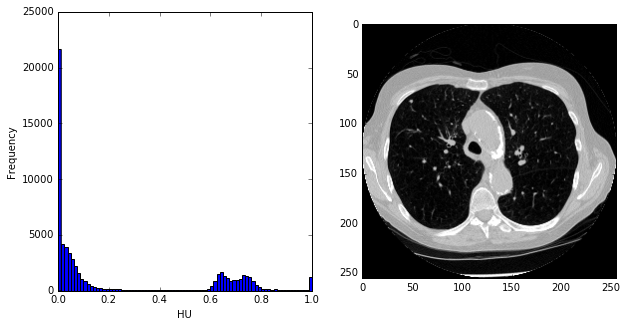

In [253]:
sn=70

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(X_test[sn].flatten(), bins=80)
plt.xlabel("HU")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,2,2)
plt.imshow(X_test[sn,0], cmap='gray')
plt.show()

## AI model

In [259]:
# training params
params_train={
    'img_rows': h,
    'img_cols': w,           
    'weights_path': None,        
    'learning_rate': 3e-4,
    'optimizer': 'Adam',
    #'loss': 'binary_crossentropy',
    'loss': 'mean_squared_error',
    #'loss': 'dice',
    'nbepoch': 1000,
    'nb_output': nb_output,
    'nb_filters': 8,    
    'max_patience': 50    
        }

model = model(params_train)
model.summary()

# path to weights
path2weights=weightfolder+"/weights.hdf5"

if not os.path.isfile(path2weights):
    raise IOError("Path to weights does not exist!")
else:
    # load best weights
    model.load_weights(path2weights)
    print ('weights loaded!')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_126 (Convolution2D)(None, 8, 128, 128)   80          convolution2d_input_11[0][0]     
____________________________________________________________________________________________________
convolution2d_127 (Convolution2D)(None, 16, 128, 128)  1168        convolution2d_126[0][0]          
____________________________________________________________________________________________________
convolution2d_128 (Convolution2D)(None, 16, 128, 128)  2320        convolution2d_127[0][0]          
____________________________________________________________________________________________________
maxpooling2d_51 (MaxPooling2D)   (None, 16, 64, 64)    0           convolution2d_128[0][0]          
___________________________________________________________________________________________

## evaluate AI model on test data from LUNA 2016

In [260]:
y_test=mask2coord(Y_test)
score_test=model.evaluate(X_test,y_test,verbose=0)
print 'loss test: %s' %score_test

loss test: 0.0115837360046


### display some of slices and detected nodules

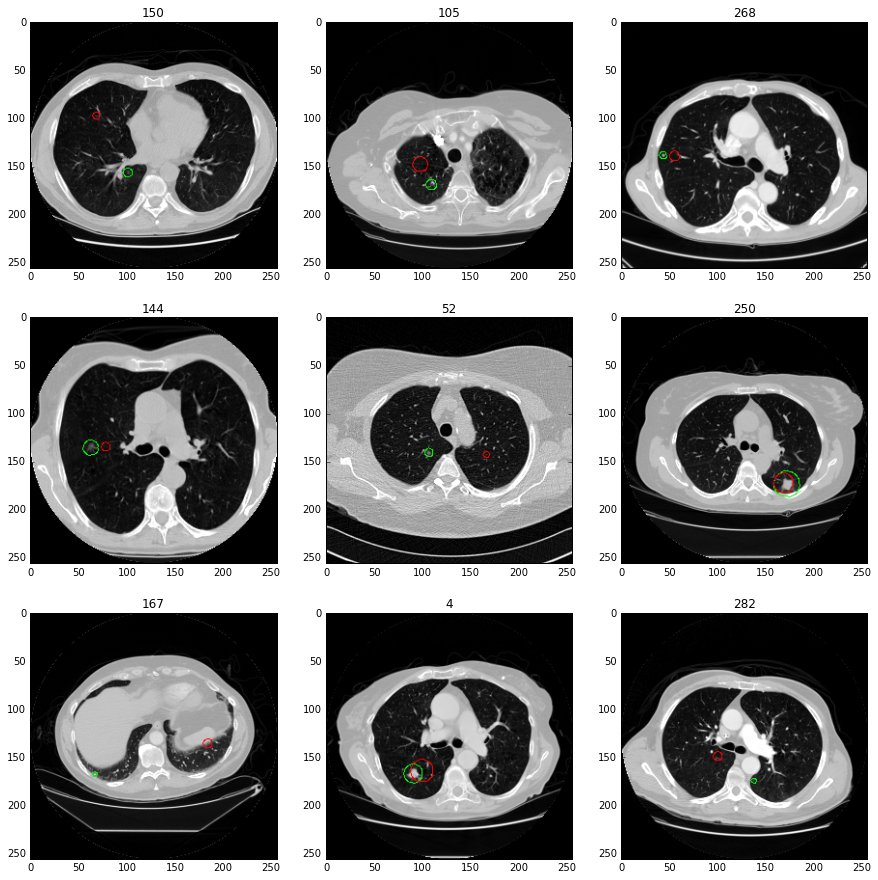

In [267]:
X,Y=X_test,Y_test

# prediction
y_pred=model.predict(X)    
#y_pred=(y_p*[h,w,100])#.astype('int16')

# convert coordinates to mask
Y_pred=coord2mask(y_pred,(h,w,100))

plt.figure(figsize=(15,15))
n1=disp_img_2masks(X,Y,Y_pred,3,3,0)
plt.show()

## DSB data

In [154]:
path2output='./output/data/dsb/'

df_train = pd.read_csv('../stage1_labels.csv')
print('Number of training patients: {}'.format(len(df_train)))
print('Cancer rate: {:.4}%'.format(df_train.cancer.mean()*100))
df_train.head()


Number of training patients: 1397
Cancer rate: 25.91%


,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


## load DSB from numpy files

In [276]:
p=1
# get patinet id and cancer status
p_id=df_train.id[p] # patient id
y=df_train.cancer[p] # patinet cancer
print 'patient %s, cancer=%s, wait ...' %(p_id,y)


f=np.load(path2output+df_train.id[p]+'.npz')
X_dsb=f['X']
if len(X_dsb.shape)==3:
    X_dsb=X_dsb[:,np.newaxis,:]

array_stats(X_dsb)


patient 0030a160d58723ff36d73f41b170ec21, cancer=0, wait ...
(u'X_dsb', (265, 1, 512, 512), dtype('int16'))
min: -1024, max: 3072, avg: -5.25e+02, std:4.85e+02
--------------------------------------------------


### checking histogram

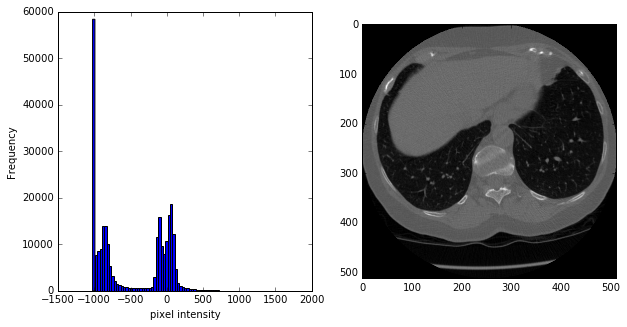

In [277]:
sn=60

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(X_dsb[sn].flatten(), bins=80)
plt.xlabel("pixel intensity")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,2,2)
plt.imshow(X_dsb[sn,0], cmap='gray')
plt.show()

## load DSB directly from dicom

(u'X_dsb', (265, 1, 512, 512), dtype('int16'))
min: -3024, max: 3072, avg: -9.51e+02, std:1.15e+03
--------------------------------------------------


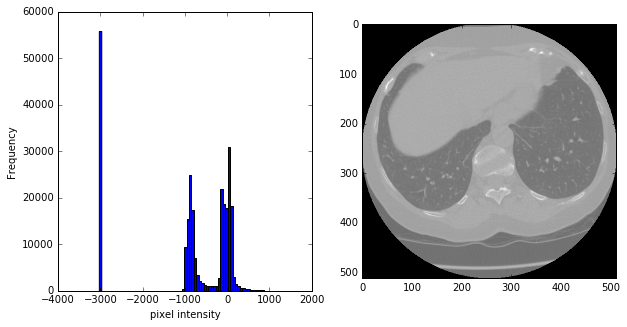

In [280]:
# load scan
scan=load_scan(path2dicom+p_id)

# convert to HU
X_dsb=get_pixels_hu(scan)
if len(X_dsb.shape)==3:
    X_dsb=X_dsb[:,np.newaxis,:]
array_stats(X_dsb)

sn=60
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(X_dsb[sn].flatten(), bins=80)
plt.xlabel("pixel intensity")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,2,2)
plt.imshow(X_dsb[sn,0], cmap='gray')
plt.show()

### preprocessing DSB

(u'X_dsb', (265, 1, 256, 256), dtype('float32'))
min: 0.0, max: 1.0, avg: 0.341, std:0.339
--------------------------------------------------
(u'Y_dsb', (265, 1, 256, 256), dtype('uint8'))
min: 0, max: 0, avg: 0.0, std:0.0
--------------------------------------------------


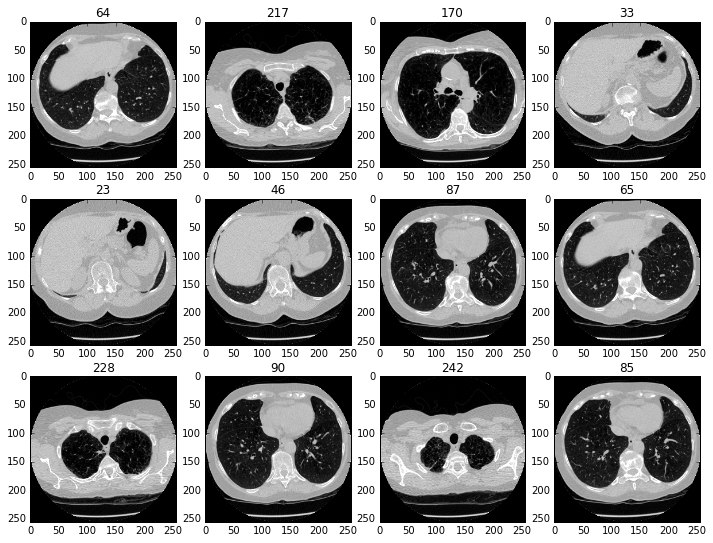

In [281]:
# pre-processing 
param_prep={
    'h': h,
    'w': w,
    'crop'    : None,
    'norm_type' : 'minmax_bound',
    'output' : 'mask',
}
X_dsb,Y_dsb=preprocess(X_dsb,None,param_prep)
array_stats(X_dsb)
array_stats(Y_dsb)

t=3
plt.figure(figsize=(4*t,3*t))
n1=disp_img_2masks(X_dsb,None,None,3,4,True)

### checking histogram after preprocessing

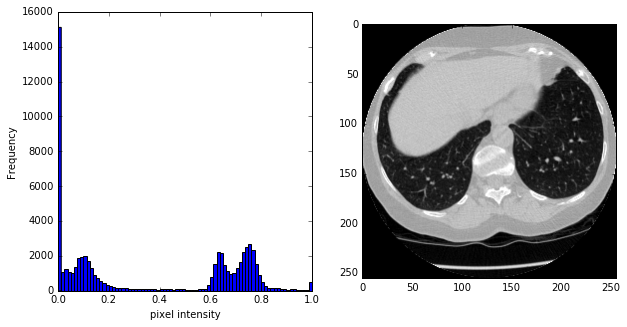

In [282]:
sn=60

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(X_dsb[sn].flatten(), bins=80)
plt.xlabel("pixel intensity")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,2,2)
plt.imshow(X_dsb[sn,0], cmap='gray')
plt.show()

### test AI model on DSB

In [283]:
X,Y=X_dsb,Y_dsb

# prediction
y_pred=model.predict(X)    

# convert coordinates to masks
coord2mask(y_pred,(h,w,100))

# find largest nodule    
ind_largest=np.argmax(y_pred[:,2])
print 'largest nodule is in slice: %s' %ind_largest
print 'largest nodule: %s' %y_pred[ind_largest]    

largest nodule is in slice: 124
largest nodule: [ 0.30013004  0.2344964   0.08659285]


### display sample slices and detected nodules

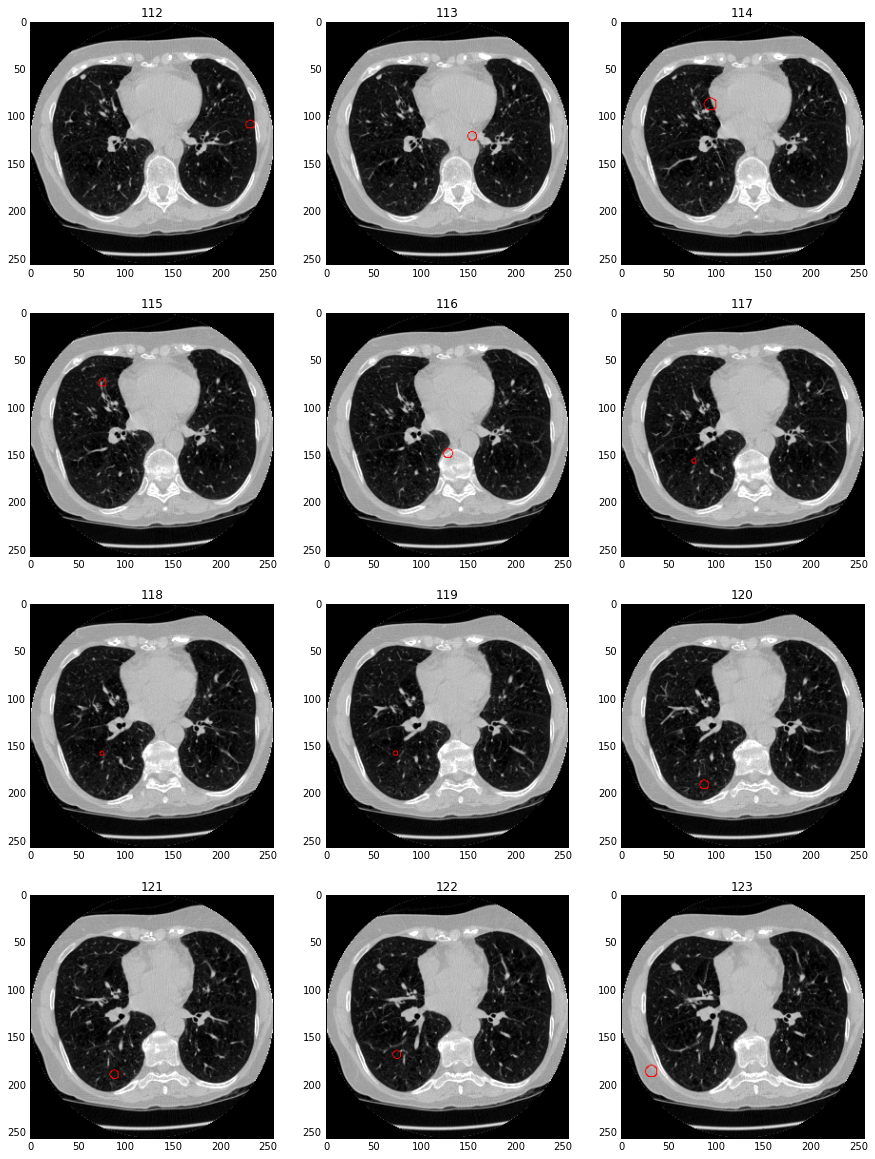

In [287]:
plt.figure(figsize=(15,20))
n=7
n1=disp_img_2masks(X,Y,Y_pred,4,3,0,range(16*n,16*n+16))
plt.show()